In [3]:
%load_ext autoreload
%autoreload 2
import palm_tools
from palm_tools.processing import *
from palm_tools import Experiment
from palm_tools.analysis import MMDInterGroupAnalysis, MMDInterUnitAnalysis, MDSAnalysis
from palm_tools.post_processing.gratin import Gratin, GratinParameters
from palm_tools.post_processing.diffusivity import StepsAndDiffusion
from palm_tools.post_processing.ts_post_processing import PostProcessingStepSeries
print(palm_tools.__version__)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.1.dev108+g6dd6dfe.d20220808


In [4]:
exp = Experiment(data_folder="/Users/hverdier/palm_tools_data/DATA_FOLDER",
    export_folder="/Users/hverdier/palm_tools_data/EXPORT_FOLDER")

In [5]:
# Indicate conditions in the index_df table of the Experiment
# This can be done automatically if you create a subclass of Experiment
exp.index_df["condition"] = "A"
exp.index_df.loc[exp.index_df.file.str.contains("B"),"condition"] = "B"

In [6]:
tp = TifPipeline.from_dict({"name":"coucou"})

In [7]:
tp = TifPipeline.from_dict({
    "name":"test",
    "movie_preprocessors":[{"WindowPercentileFilter":{"percentile":10,"window_size":300}}]
})

In [8]:
tp2 = TifPipeline.from_dict({
    "name":"stricter_than_default",
    "localizer":{"DefaultLocalizer":{"threshold_factor":1.5}},
})

In [9]:
print(tp2)

TIF Processing pipeline
-----------------------
Movie preprocessing steps :
-----------------------
Localizer :
	 Default Localizer (DefaultLocalizer) :
		 threshold_factor : 1.5

-----------------------
Localization processing steps :
-----------------------
Tracker :
	 Default tracker (Trackpy) (TrackpyTracker) :
		 max_diffusivity : 5.0




In [10]:
tp2.to_yaml("/Users/hverdier/palm_tools_data/pipeline2.yaml")

In [11]:
tp2 = TifPipeline.from_yaml("/Users/hverdier/palm_tools_data/pipeline2.yaml")

In [12]:
acq = Acquisition(exp[0],experiment=exp, tif_pipeline=tp)

In [13]:
tp.process(acq)

In [14]:
acq.locs

This acquisition wasn't localized. Or perhaps with another Pipeline ?


In [13]:
acq.locs.head()

This acquisition wasn't localized. Or perhaps with another Pipeline ?


AttributeError: 'NoneType' object has no attribute 'head'

In [14]:
tp2.open_in_napari(acq=acq)

In [ ]:
# Run pipeline on just one acquisition
acq = Acquisition(exp[0],experiment=exp, tif_pipeline=tp)
tp.process(acq)

In [10]:
# Run pipeline on all experience's acquisitions
tp.process(exp)

In [11]:
# Open Napari viewer
# acq.view(min_traj_length=7)

In [12]:
# Create tracksets
tss = exp.to_tracksets(tif_pipeline=tp)

Opening /Users/hverdier/palm_tools_data/EXPORT_FOLDER/test/1aeb07e6d906fa6d.locs
Index([',frame,x,y,ratio,sigma,total_intensity,t,n'], dtype='object')
Not enough columns
Error with separator |	|
Index column : Unnamed: 0
            frame         x         y     ratio     sigma  total_intensity  \
Unnamed: 0                                                                   
0               0  2.379036  5.257908  1.218708  3.985672           2927.0   
1               0  2.575154  3.404722  3.462057  4.371380           5639.0   
2               0  3.662238  1.832627  1.421831  4.025060           5353.0   
3               0  5.393937  1.539515  1.089570  3.720945           6372.0   
4               1  2.233052  2.638632  1.888237  3.821032           7148.0   

               t  n  
Unnamed: 0           
0           0.00  0  
1           0.00  1  
2           0.00  2  
3           0.00  3  
4           0.03  4  
Sorted column is time or frame
frame is frame
Sorted column is time or frame
t

In [23]:
gratin_path = "/Users/hverdier/models/demo"
#Gratin.train_model(export_path=gratin_path,time_delta=exp.DT)

In [40]:
gt = Gratin(GratinParameters(path=gratin_path))
sd = StepsAndDiffusion()

In [43]:
pps = PostProcessingStepSeries(processing_steps=[sd,gt])

In [56]:
pps.process(tss)

Processing in PPSS : 100%|██████████| 9/9 [00:00<00:00, 281.17it/s, CONDITION B/Exp1/cellZone0/ROI.tif : Gratin latent vectors and output]


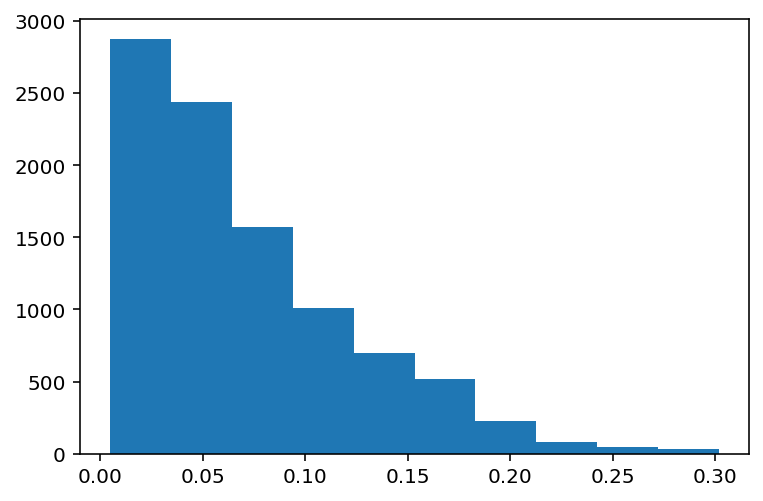

In [59]:
for ts in tss:
    plt.hist(ts.locs["est_sigma"])
    break

In [29]:
exp.index_df

file                ID condition
0     CONDITION A/Experience1/CellZone1/ROI.tif  4c673d7a3babf12f         A
1     CONDITION A/Experience1/CellZone0/ROI.tif  0a4f0c4d5a770f14         A
2     CONDITION A/Experience0/CellZone2/ROI.tif  1aeb07e6d906fa6d         A
3     CONDITION A/Experience0/CellZone1/ROI.tif  272126b5e72b50a4         A
4   CONDITION A/Experience0/CellZone0/ROI#0.tif  e050273c2b28d429         A
5          CONDITION B/Exp0/cellZone2/ROI#0.tif  448d0bb5d719692d         B
6            CONDITION B/Exp0/cellZone1/ROI.tif  22ec7db7a6a63186         B
7            CONDITION B/Exp0/cellZone0/ROI.tif  2cf987b2e99bb1ed         B
8            CONDITION B/Exp1/cellZone2/ROI.tif  0628d1f1d8516a68         B
9            CONDITION B/Exp1/cellZone1/ROI.tif  662132ba6f8b14f0         B
10           CONDITION B/Exp1/cellZone0/ROI.tif  1e473395599b752f         B

In [28]:
mmd_group = MMDInterGroupAnalysis(
    track_sets=tss,
    group_by_keys=["condition"],
    run_name="demo",
    n_processes=4,
)

In [30]:
mmd_group.groups

Adding units from tracksets: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s, 2438 trajs from CONDITION B/Exp1/cellZone0/ROI.tif]        


latent_df has 9 units


[{'condition': 'A'}, {'condition': 'B'}]

In [31]:
mmd_group.process(force_recompute=True)

  0%|          | 0/1 [00:00<?, ?it/s]

# units 
	 A : 3
	 B : 6
min_n = 532 (650, 532)
# of trajs : 1596 vs 3192
# combinations = 84


(50 bootstraps) : {'condition': 'A'} VS {'condition': 'B'}: 100%|██████████| 1/1 [00:28<00:00, 28.79s/it]


Interpolations are done
Looking at critical trajectories


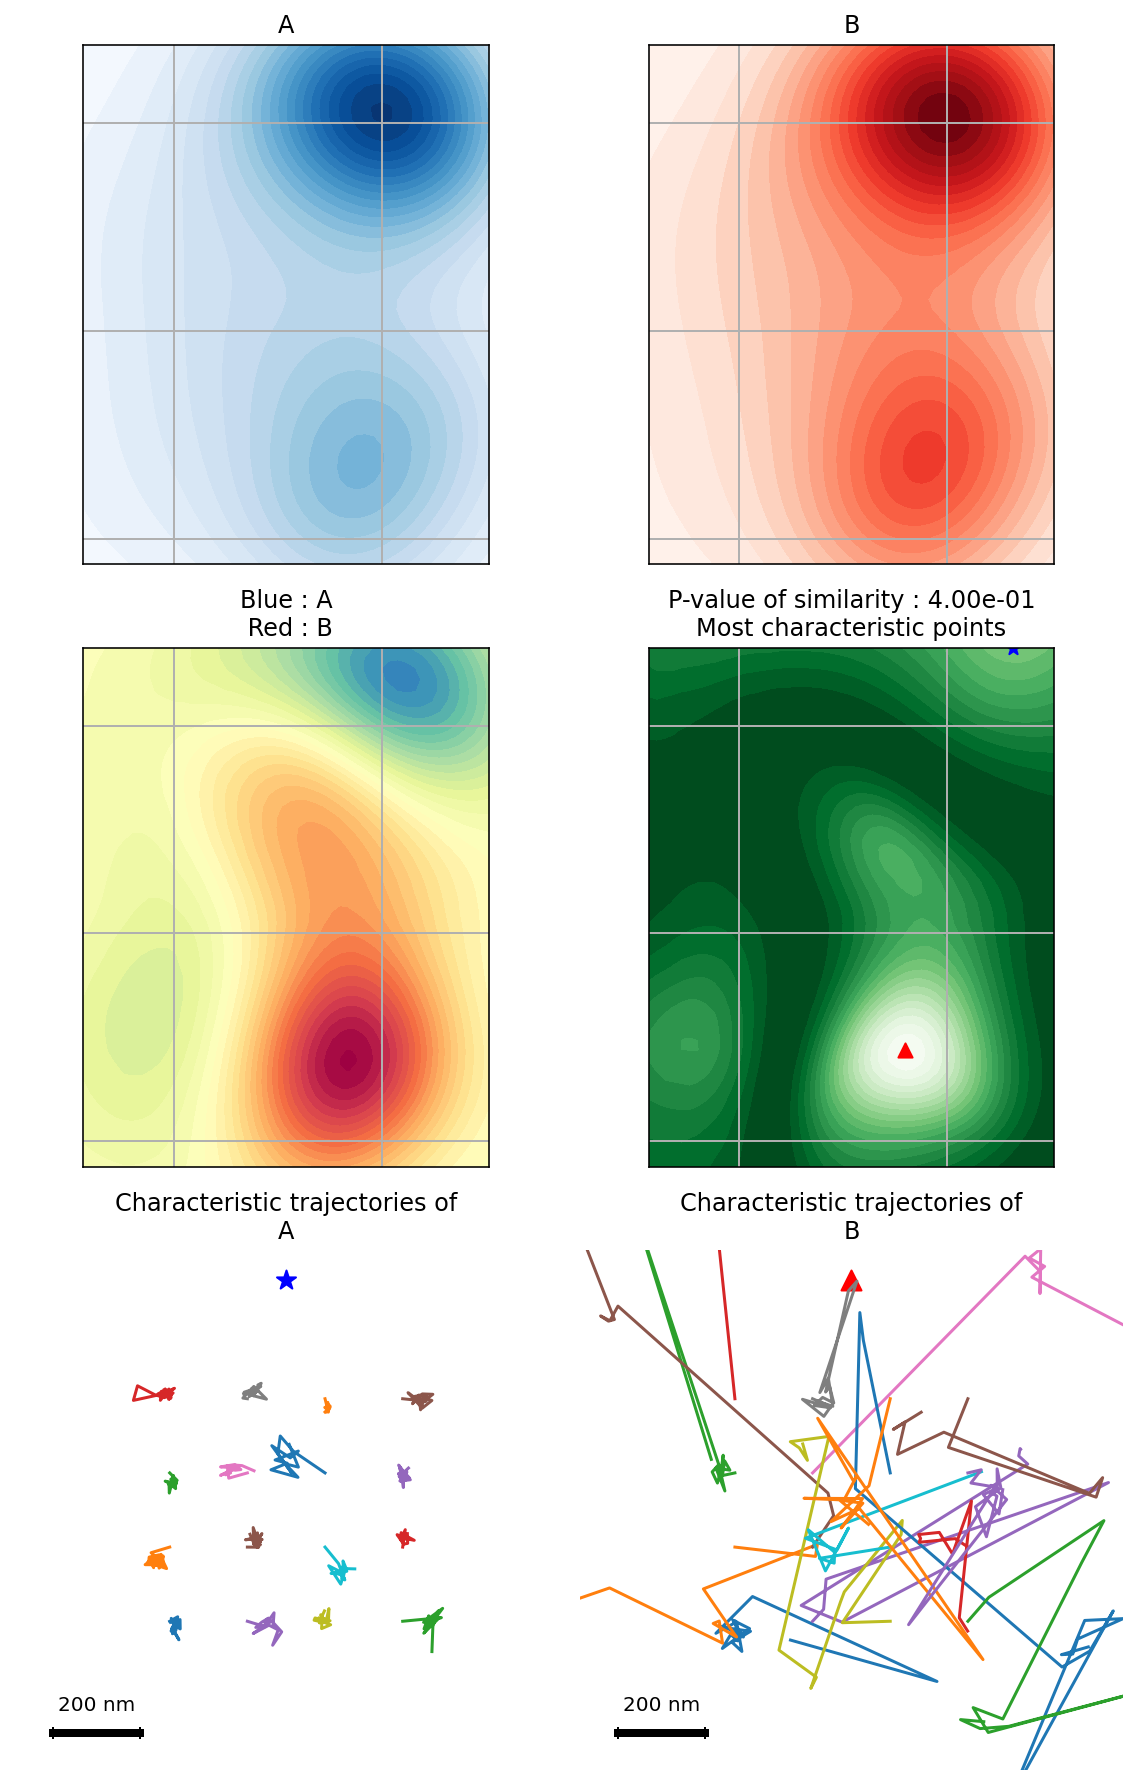

In [32]:
mmd_group.plot_discriminant_trajs(cond1={"condition":"A"},cond2={"condition":"B"})

/Users/hverdier/palm-tools/src/palm_tools/analysis/mmd_analysis.py:831: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


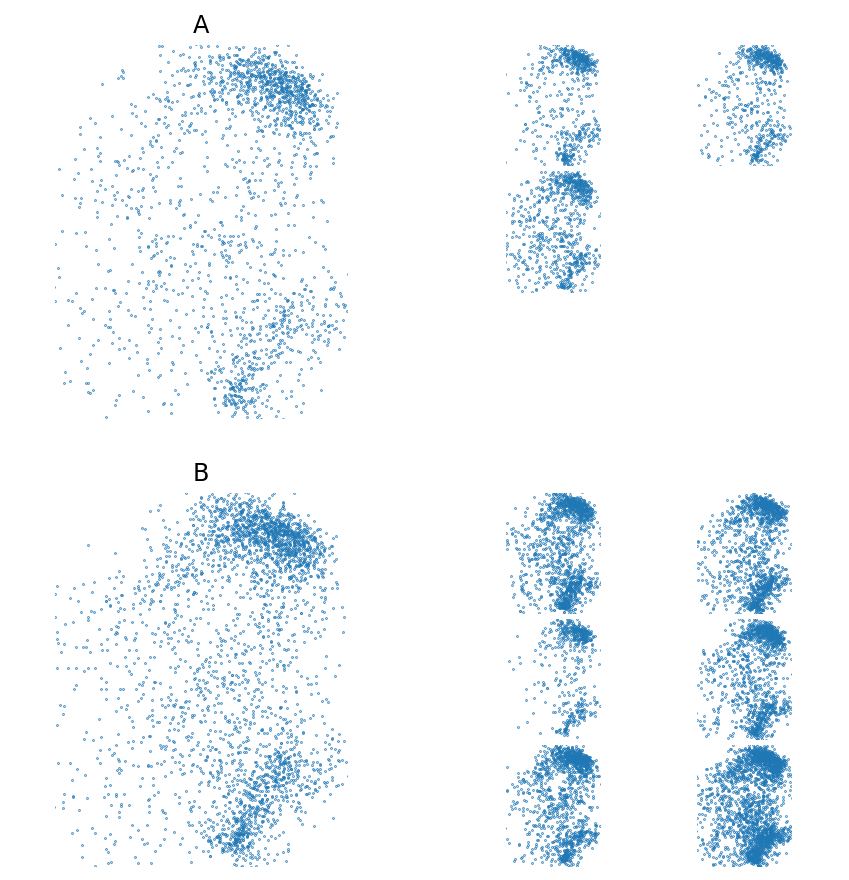

In [33]:
mmd_group.plot_latent_spaces(groups={"condition":["A","B"]},show_scatter=True)

In [34]:
mmd_unit = MMDInterUnitAnalysis(
    track_sets=tss,
    run_name="demo",
    n_processes=4
    )

In [35]:
mmd_unit.units

Adding units from tracksets: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s, 2438 trajs from CONDITION B/Exp1/cellZone0/ROI.tif]        


latent_df has 9 units


{0: {'file': 'CONDITION A/Experience0/CellZone2/ROI.tif'},
 1: {'file': 'CONDITION A/Experience0/CellZone0/ROI#0.tif'},
 2: {'file': 'CONDITION A/Experience0/CellZone1/ROI.tif'},
 3: {'file': 'CONDITION B/Exp0/cellZone2/ROI#0.tif'},
 4: {'file': 'CONDITION B/Exp0/cellZone1/ROI.tif'},
 5: {'file': 'CONDITION B/Exp0/cellZone0/ROI.tif'},
 6: {'file': 'CONDITION B/Exp1/cellZone2/ROI.tif'},
 7: {'file': 'CONDITION B/Exp1/cellZone1/ROI.tif'},
 8: {'file': 'CONDITION B/Exp1/cellZone0/ROI.tif'}}

In [36]:
mmd_unit.process()

Computing MMD...: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
